In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_checkerboard

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


In [19]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch

batch_size = 64
epochs = 3
lr = 1e-3

model = BinarizedMNISTClassifier().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1/3 | Train Loss: 0.1509, Accuracy: 95.34% | Test Loss: 0.0586, Accuracy: 97.92% | LR: 0.00100000
Epoch 2/3 | Train Loss: 0.0457, Accuracy: 98.59% | Test Loss: 0.0544, Accuracy: 98.19% | LR: 0.00100000
Epoch 3/3 | Train Loss: 0.0262, Accuracy: 99.14% | Test Loss: 0.0439, Accuracy: 98.54% | LR: 0.00100000


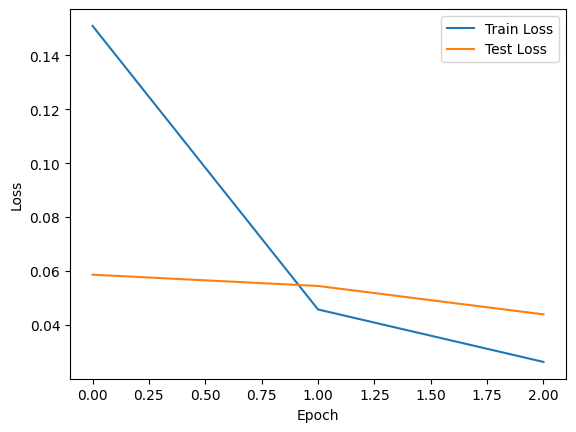

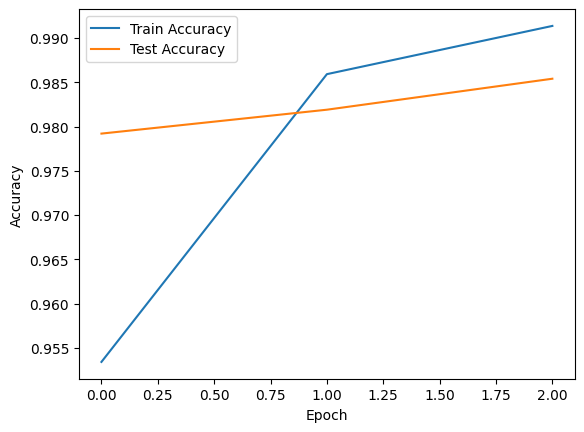

In [ ]:
from datasets.binarized_mnist import build_dataloaders

train_loader, test_loader = build_dataloaders(batch_size=batch_size)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for x, labels in train_loader:
        x = F.one_hot(x.long(), num_classes=2).float().to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        total = 0
        for x, labels in test_loader:
            x = F.one_hot(x.long(), num_classes=2).float().to(device)
            labels = labels.to(device)
            
            logits = model(x)
            loss = criterion(logits, labels)
            test_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        test_loss /= len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc * 100:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc * 100:.2f}% | "
          f"LR: {optimizer.param_groups[0]['lr']:.8f}")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# store model weights
torch.save(model.state_dict(), '../model_weights/binarized_mnist_classifier.pth')